In [1]:
from collections import Counter

import h5py
import joblib
import numpy as np
import pandas as pd
import plotly.express as px
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from xgboost import XGBClassifier

# Train, Test split

In [42]:
# Function to generate the training and test data
def generate_train_test_data(hdf5_out_put_file_path, train_percentage, n_pixels_lat, n_pixels_lon, cnn):
    with h5py.File(hdf5_out_put_file_path, 'r') as file:
        sequences = list(file.keys())
        n_sequences = len(sequences)
        n_train_sequences = int(train_percentage * n_sequences)
        n_train_samples = n_pixels_lat * n_pixels_lon * n_train_sequences
        n_test_sequences = n_sequences - n_train_sequences
        n_test_samples = n_pixels_lat * n_pixels_lon * n_test_sequences

        print("n_train", n_train_sequences, "n_test", n_test_sequences)
        print("total number of sequences", n_train_sequences + n_test_sequences)
        print("n_sequences", n_sequences)
        print("n_train_samples", n_train_samples)
        print("n_test_samples", n_test_samples)

        if not cnn:
            x_train = np.zeros((n_train_samples, 1))
            y_train = np.zeros(n_train_samples)
            x_test = np.zeros((n_test_samples, 1))
            y_test = np.zeros(n_test_samples)

            sample_index = 0
            for i in range(n_train_sequences):
                group = file[sequences[i]]
                interpolated_displacement = group['interpolated_displacement'][()].reshape(-1, 5)

                # Remove masked pixels
                mask = interpolated_displacement[:, -1] == 1
                #print(mask.sum())
                interpolated_displacement = interpolated_displacement[mask]

                labels = group['labels'][()].flatten()
                labels = labels[mask]

                print(interpolated_displacement)
                interpolated_displacement = interpolated_displacement[..., 3]
                interpolated_displacement = interpolated_displacement.reshape(-1, 1)

                print(interpolated_displacement)
                #sys.exit()

                n_samples = interpolated_displacement.shape[0]
                x_train[sample_index:sample_index + n_samples] = interpolated_displacement
                y_train[sample_index:sample_index + n_samples] = labels

                sample_index += n_samples

            # Remove excess zeros
            x_train = x_train[:sample_index]
            y_train = y_train[:sample_index]
            sample_index = 0
            for i in range(n_train_sequences, n_sequences):
                group = file[sequences[i]]
                interpolated_displacement = group['interpolated_displacement'][()].reshape(-1, 5)

                # Remove masked pixels
                mask = interpolated_displacement[:, -1] == 1
                interpolated_displacement = interpolated_displacement[mask]
                labels = group['labels'][()].flatten()
                labels = labels[mask]

                interpolated_displacement = interpolated_displacement[..., 3]
                interpolated_displacement = interpolated_displacement.reshape(-1, 1)

                n_samples = interpolated_displacement.shape[0]
                x_test[sample_index:sample_index + n_samples] = interpolated_displacement
                y_test[sample_index:sample_index + n_samples] = labels

                sample_index += n_samples
            # Remove excess zeros
            x_test = x_test[:sample_index]
            y_test = y_test[:sample_index]

            return x_train, y_train, x_test, y_test

In [3]:
def bootstrap_cross_validation_with_kfold(X, y, n_bootstraps, model_class, model_params):
    kfold = KFold(n_splits=10)
    final_predictions = np.zeros(len(y))

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Store models and their predictions
        models = []
        val_predictions = np.zeros((len(y_val), n_bootstraps))

        # Bootstrapping within each fold
        for i in range(n_bootstraps):
            # Create bootstrapped dataset
            X_resampled, y_resampled = resample(X_train, y_train, n_samples=len(X_train), replace=True)

            # Train the model
            model = model_class(**model_params)
            model.fit(X_resampled, y_resampled)

            models.append(model)

            # Predict on validation set
            val_predictions[:, i] = model.predict_proba(X_val)[:, 1]  # Assuming binary classification

        # Compute soft averaged predictions for each validation sample
        fold_final_predictions = np.zeros(len(y_val))
        for j in range(len(y_val)):
            # Exclude models that trained on the j-th sample
            exclude_models = [i for i, model in enumerate(models) if y_val[j] in model.classes_]
            included_predictions = np.delete(val_predictions[j, :], exclude_models)

            # Soft average
            fold_final_predictions[j] = np.mean(included_predictions)

        final_predictions[val_index] = fold_final_predictions

    return final_predictions

# Parameters

In [4]:
#Path to the HDF5 output file
hdf5_out_put_file_path = "Data/Interpolated_Data_reg=False_soft_labels=False_elasticity=True_min_mainshock_mag=6_min_stations_per_main_shock=3_min_after_shock_mag=4_after_shock_time_window=45_n_days_before_mainshock=1_n_days_after_mainshock=1.hdf5"
train_percentage = 0.8
test_percentage = 1 - train_percentage
n_pixels_lat = 50  # Number of pixels in the latitude direction
n_pixels_lon = 50  # Number of pixels in the longitude direction
cnn = False  # Whether to use a CNN model

In [5]:
x_train, y_train, x_test, y_test = generate_train_test_data(hdf5_out_put_file_path, train_percentage, n_pixels_lat,
                                                            n_pixels_lon, cnn)

n_train 119 n_test 30
total number of sequences 149
n_sequences 149
n_train_samples 297500
n_test_samples 75000
[[-9.65615931e-01  2.24747626e+00  1.03348125e-01  9.23373532e+01
   1.00000000e+00]
 [-9.31637685e-01  2.24688280e+00  1.09756381e-01  8.85855313e+01
   1.00000000e+00]
 [-8.99847076e-01  2.24623599e+00  1.15368309e-01  8.48629292e+01
   1.00000000e+00]
 ...
 [-6.89373477e-01  2.22337447e+00  1.25157785e-01  1.22415604e+02
   1.00000000e+00]
 [-6.88270512e-01  2.22414637e+00  1.14085614e-01  1.21682591e+02
   1.00000000e+00]
 [-6.88707566e-01  2.22486156e+00  1.02946614e-01  1.21079552e+02
   1.00000000e+00]]
[[ 92.33735315]
 [ 88.58553127]
 [ 84.86292917]
 [ 81.17356781]
 [ 77.52219405]
 [ 73.91443868]
 [ 70.35701279]
 [ 66.85795157]
 [ 63.42691592]
 [ 60.07556298]
 [ 56.81799526]
 [ 53.67129306]
 [ 50.65612181]
 [ 47.79738056]
 [102.13173907]
 [ 98.25072489]
 [ 94.3854313 ]
 [ 90.53787263]
 [ 86.71041059]
 [ 82.90582944]
 [ 79.12743056]
 [ 75.37915209]
 [ 71.6657211 ]
 [ 6

In [6]:
x_train[y_train == 1]

array([[ 57.33425071],
       [ 90.36199996],
       [102.2187354 ],
       ...,
       [ 42.00036365],
       [ 45.0391989 ],
       [ 74.55009899]])

In [7]:
x_train.shape

(135279, 1)

In [8]:
y_train

array([0., 0., 0., ..., 0., 0., 0.])

In [9]:
y_train.shape

(135279,)

In [10]:
y_train.sum()

1446.0

In [11]:
np.histogram(y_train[y_train>1e-4], 100)

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 1446,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]),
 array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
        0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
        0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
        0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
        0.94, 0.95, 0.

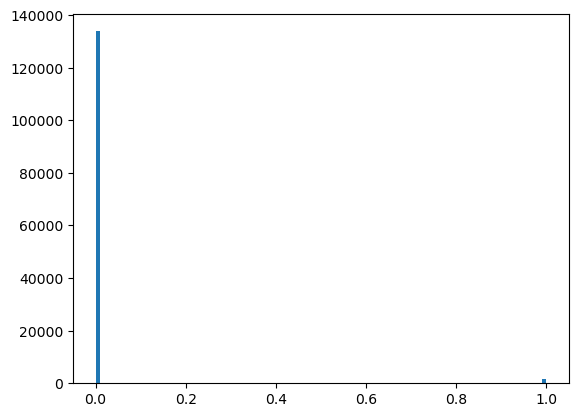

In [12]:
import matplotlib.pyplot as plt
plt.hist(y_train, 100)
plt.show()

In [13]:
y = np.concatenate((y_train, y_test))



class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]

class_weight_options = {0: 1, 1: scale_pos_weight}

lr = LogisticRegression(random_state=42, n_jobs=-1, class_weight= class_weight_options)

lr.fit(x_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 92.5539419087137}, n_jobs=-1,
                   random_state=42)

In [14]:
np.unique(y_train)

array([0., 1.])

In [15]:
#lr.fit(x_train, y_train)

In [16]:
y_train_pred = lr.predict(x_train)
train_score = metrics.balanced_accuracy_score(y_train, y_train_pred)

In [17]:
train_score

0.5448426497840422

# Oversampling the training set

In [18]:
# Oversampling the training set using SMOTE
oversampler = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = oversampler.fit_resample(x_train, y_train)

In [19]:
Counter(y_train_resampled)

Counter({0.0: 133833, 1.0: 133833})

In [20]:
lr_resampled = LogisticRegression(random_state=42, n_jobs=-1)
lr_resampled.fit(x_train_resampled, y_train_resampled)

LogisticRegression(n_jobs=-1, random_state=42)

In [21]:
y_train_pred_resampled = lr_resampled.predict(x_train_resampled)
train_score_resampled = metrics.balanced_accuracy_score(y_train_resampled, y_train_pred_resampled)

In [22]:
train_score_resampled

0.5446339841444188

# Baseline models

In [23]:
# Calculate the scale_pos_weight hyperparameter for XGBoost
# This is used to balance the positive and negative class weights. Since the dataset is imbalanced, we want to give more weight to the positive class.
class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]

# Calculate the class_weight hyperparameter for SVM
class_weight_options = {0: 1, 1: scale_pos_weight}

# Defining models
models = [
    {
        'name': 'Random Forest Classifier',
        'estimator': RandomForestClassifier(random_state=42, n_jobs=-1,
                                            class_weight=class_weight_options)
    },
    {
        'name': 'XGBoost Classifier',
        'estimator': XGBClassifier(random_state=42, n_jobs=-1,
                                   scale_pos_weight=scale_pos_weight)
    },
    {
        'name': 'LightGBM Classifier',
        'estimator': LGBMClassifier(random_state=42, n_jobs=-1,
                                    class_weight=class_weight_options)
    },
    {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(random_state=42, n_jobs=-1,
                                        class_weight=class_weight_options)
    }
]


# Function to evaluate a baseline model
def evaluate_baseline_model(x_train, y_train, x_test, y_test, model, model_name):
    pipeline = make_pipeline(
        #SMOTE(random_state=42),
        model)

    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    y_probas = pipeline.predict_proba(x_test)
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_probas[:, 1])
    # Calculate the area under the precision-recall curve
    auprc = metrics.auc(recall, precision)
    auroc = metrics.roc_auc_score(y_test, y_probas[:, 1])
    return {
        'Model': model_name,
        'Recall': metrics.recall_score(y_test, y_pred, average='binary'),
        'Balanced Accuracy': metrics.balanced_accuracy_score(y_test, y_pred),
        'AUROC': auroc,
        'F1 Score': metrics.f1_score(y_test, y_pred, average='binary'),
        'AUPRC': auprc,
        'Accuracy': metrics.accuracy_score(y_test, y_pred)
    }, conf_matrix

In [24]:
def plot_confusion_matrix(conf_matrix, model_name):
    fig = px.imshow(conf_matrix, labels=dict(x="Predicted", y="True"),
                    x=['No Aftershock', 'Aftershock'], y=['No Aftershock', 'Aftershock'],
                    color_continuous_scale='Viridis',
                    color_continuous_midpoint=np.average(conf_matrix),
                    title=f"Confusion Matrix for {model_name}",
                    text_auto=True)
    fig.show()

# Train score

In [25]:
# Iterate through models and evaluate them
results_train = []
for model in models:
    score, conf_matrix = evaluate_baseline_model(x_train, y_train, x_train, y_train,
                                                 model['estimator'], model['name'])
    plot_confusion_matrix(conf_matrix, model['name'])
    results_train.append(score)

# Convert scores to a DataFrame
results_df_train = pd.DataFrame(results_train)

[LightGBM] [Info] Number of positive: 1446, number of negative: 133833
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 135279, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [26]:
results_df_train

Model    Recall  Balanced Accuracy     AUROC  F1 Score  \
0  Random Forest Classifier  0.985477           0.986163  0.994204  0.615418   
1        XGBoost Classifier  0.627248           0.621239  0.675453  0.033687   
2       LightGBM Classifier  0.572614           0.616229  0.669896  0.034646   
3       Logistic Regression  0.491701           0.544843  0.588071  0.025411   

      AUPRC  Accuracy  
0  0.463278  0.986835  
1  0.044684  0.615358  
2  0.044342  0.658912  
3  0.026288  0.596848

# Test score

In [27]:
x_test

array([[169.93083065],
       [166.84596271],
       [163.83243624],
       ...,
       [145.59992798],
       [147.85907755],
       [150.18691392]])

In [28]:
y_test.shape

(37334,)

In [29]:
y_test.sum()

119.0

In [30]:
x_test.shape

(37334, 1)

In [32]:
# Iterate through models and evaluate them
results_test = []
for model in models:
    score, conf_matrix = evaluate_baseline_model(x_train, y_train, x_test, y_test,
                                                 model['estimator'], model['name'])
    plot_confusion_matrix(conf_matrix, model['name'])
    results_test.append(score)

# Convert scores to a DataFrame
results_df_test = pd.DataFrame(results_test)

[LightGBM] [Info] Number of positive: 1446, number of negative: 133833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 135279, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [33]:
results_df_test

Model    Recall  Balanced Accuracy     AUROC  F1 Score  \
0  Random Forest Classifier  0.151261           0.565621  0.577561  0.040816   
1        XGBoost Classifier  0.672269           0.644102  0.723413  0.011041   
2       LightGBM Classifier  0.638655           0.651129  0.717150  0.011955   
3       Logistic Regression  0.722689           0.668546  0.743811  0.011817   

      AUPRC  Accuracy  
0  0.029769  0.977340  
1  0.124236  0.616114  
2  0.114861  0.663524  
3  0.062354  0.614748

# Hyperparameter optimization

In [ ]:
CV = 5  # Number of cross-validation folds

In [ ]:
# Defining models and their hyperparameters
models = [
    {
        'name': 'Random Forest Classifier',
        'estimator': RandomForestClassifier(random_state=42, n_jobs=-1),
        'hyperparameters': {
            'model__n_estimators': [100, 300],
            'model__max_depth': [None, 5, 15],
            'model__min_samples_split': [3, 5],
            'model__min_samples_leaf': [1, 3],
            'model__bootstrap': [True],
            'model__criterion': ['gini', 'entropy']
        }
    },
    {
        'name': 'XGBoost',
        'estimator': XGBClassifier(random_state=42, objective='binary:logistic',
                                   n_jobs=-1),
        'hyperparameters': {
            'model__max_depth': [0, 5, 15],
            'model__learning_rate': [0.01, 0.1],
            'model__n_estimators': [100, 300],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0],
        }
    },
    {
        'name': 'LightGBM',
        'estimator': LGBMClassifier(random_state=42, objective='binary', n_jobs=-1),
        'hyperparameters': {
            #'model__num_leaves': [15, 31, 63],
            'model__learning_rate': [0.01, 0.1],
            'model__n_estimators': [100, 300],
            'model__max_depth': [-1, 5, 15],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0],
        }
    },
    {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(random_state=42, n_jobs=-1),
        'hyperparameters': {
            'model__max_iter': [100, 1000],
            'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear']
        }
    }
]


# Function to perform model training, evaluation, and printing results
def evaluate_model(x_train, y_train, x_test, y_test, model_dict, hyperparameters):
    model = model_dict['estimator']
    results = []
    pipeline = Pipeline(steps=[('model', model)])

    # Defining the scoring metrics
    # scoring_metrics = {
    #'recall': metrics.make_scorer(metrics.recall_score, average='binary'),
    # balanced_accuracy = metrics.make_scorer(metrics.balanced_accuracy_score),
    #'f1_score': metrics.make_scorer(metrics.f1_score, average='binary')
    # }
    grid_search = model_selection.GridSearchCV(pipeline, hyperparameters,
                                               scoring=metrics.make_scorer(metrics.recall_score, average='binary'),
                                               n_jobs=-1,
                                               cv=CV,
                                               refit=True
                                               )
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test)
    # Conf matrix
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    #print(f"Confusion Matrix for {model_dict['name']}:\n{conf_matrix}")
    y_probas = best_model.predict_proba(x_test)
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_probas[:, 1])
    # Calculate the area under the precision-recall curve
    auprc = metrics.auc(recall, precision)
    auroc = metrics.roc_auc_score(y_test, y_probas[:, 1])
    results.append({
        'Model': model_dict['name'],
        'Recall': metrics.recall_score(y_test, y_pred, average='binary'),
        'Balanced Accuracy': metrics.balanced_accuracy_score(y_test, y_pred),
        'AUROC': auroc,
        'F1 Score': metrics.f1_score(y_test, y_pred, average='binary'),
        'AUPRC': auprc,
        'Accuracy': metrics.accuracy_score(y_test, y_pred)
    })

    return grid_search, results, best_model, conf_matrix

In [ ]:
grid_search_RF, results_RF, best_model_RF, conf_matrix_RF = evaluate_model(x_train, y_train, x_test,
                                                                           y_test, models[0],
                                                                           models[0]['hyperparameters'])
# Saving the best Random Forest model
joblib.dump(grid_search_RF, 'grid_search_RF.pkl')
print(f"Random Forest - Best Hyperparameters: {grid_search_RF.best_params_}")

In [ ]:
print(f"Best RF model mean CV score: {grid_search_RF.best_score_:.2%})")

In [ ]:
results_RF_df = pd.DataFrame(results_RF)
results_RF_df

In [ ]:
grid_search_RF = joblib.load('grid_search_RF.pkl')
best_model_RF = grid_search_RF.best_estimator_
y_pred = best_model_RF.predict(x_test)
# Conf matrix
conf_matrix_RF = metrics.confusion_matrix(y_test, y_pred)

In [ ]:
plot_confusion_matrix(conf_matrix_RF, 'Random Forest')

In [ ]:
grid_search_XGB, results_XGB, best_model_XGB, conf_matrix_XGB = evaluate_model(x_train, y_train,
                                                                               x_test, y_test, models[1],
                                                                               models[1]['hyperparameters'])
# Saving the best XGBoost model
joblib.dump(grid_search_XGB, 'grid_search_XGB.pkl')
print(f"XGBoost - Best Hyperparameters: {grid_search_XGB.best_params_}")

In [ ]:
print(f"Best XGB model mean CV score: {grid_search_XGB.best_score_:.2%})")

In [ ]:
results_XGB_df = pd.DataFrame(results_XGB)
results_XGB_df

In [ ]:
plot_confusion_matrix(conf_matrix_XGB, 'XGBoost')

In [ ]:
grid_search_LGBM, results_LGBM, best_model_LGBM, conf_matrix_LGBM = evaluate_model(x_train, y_train,
                                                                                   x_test, y_test, models[2],
                                                                                   models[2]['hyperparameters'])
# Saving the best LightGBM model
joblib.dump(grid_search_LGBM, 'grid_search_LGBM.pkl')
print(f"LightGBM - Best Hyperparameters: {grid_search_LGBM.best_params_}")

In [ ]:
print(f"Best LGBM model mean CV score: {grid_search_LGBM.best_score_:.2%})")

In [ ]:
results_LGBM_df = pd.DataFrame(results_LGBM)
results_LGBM_df

In [ ]:
plot_confusion_matrix(conf_matrix_LGBM, 'LightGBM')

In [ ]:
grid_search_LR, results_LR, best_model_LR, conf_matrix_LR = evaluate_model(x_train, y_train, x_test,
                                                                           y_test, models[3],
                                                                           models[3]['hyperparameters'])
#Saving the best LightGBM model
joblib.dump(grid_search_LR, 'grid_search_LR.pkl')
print(f"Logistic Regression - Best Hyperparameters: {grid_search_LR.best_params_}")

In [ ]:
print(f"Best Logistic Regression model mean CV score: {grid_search_LR.best_score_:.2%})")

In [ ]:
results_LR_df = pd.DataFrame(results_LR)
results_LR_df

In [ ]:
plot_confusion_matrix(conf_matrix_LR, 'Logistic Regression')

In [ ]:
def bootstrap_train_evaluate(X, y, model_class, model_params, n_bootstraps=100, test_size=0.2, model= LogisticRegression(random_state= 42, n_jobs = -1, class_weight= class_weight_options)):
    results = []
    n_samples = X.shape[0]
    
    for _ in range(n_bootstraps):
        # Create bootstrap sample
        bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
        X_bootstrap = X[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]
        
        # Split the bootstrap sample into train and test sets
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X_bootstrap, y_bootstrap, test_size=test_size, random_state=42
        )
        
        # Train the model
        #model = model_class(**model_params)
        model.fit(X_train, y_train)
        
        # Evaluate the model
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        results.append({
            'Recall': metrics.recall_score(y_test, y_pred, average='binary'),
            'Balanced Accuracy': metrics.balanced_accuracy_score(y_test, y_pred),
            'AUROC': metrics.roc_auc_score(y_test, y_prob),
            'F1 Score': metrics.f1_score(y_test, y_pred, average='binary'),
            'AUPRC': metrics.average_precision_score(y_test, y_prob),
            'Accuracy': metrics.accuracy_score(y_test, y_pred)
        })
    
    # Calculate mean and standard deviation of metrics
    results_df = pd.DataFrame(results)
    mean_results = results_df.mean()
    std_results = results_df.std()
    
    return mean_results, std_results

# Example usage:




In [ ]:
class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]

class_weight_options = {0: 1, 1: scale_pos_weight}

lr_params = {
    'random_state': 42,
    'n_jobs': -1,
    'class_weight': class_weight_options
}
lr_mean, lr_std = bootstrap_train_evaluate(x_train, y_train, LogisticRegression, lr_params)


print("Mean Results:")
print(lr_mean)
print("\nStandard Deviation of Results:")
print(lr_std)

(135279, 1) (135279,)
(135279, 1) (135279,)
(135279, 1) (135279,)
(135279, 1) (135279,)
(135279, 1) (135279,)
(135279, 1) (135279,)
(135279, 1) (135279,)
(135279, 1) (135279,)
(135279, 1) (135279,)
(135279, 1) (135279,)


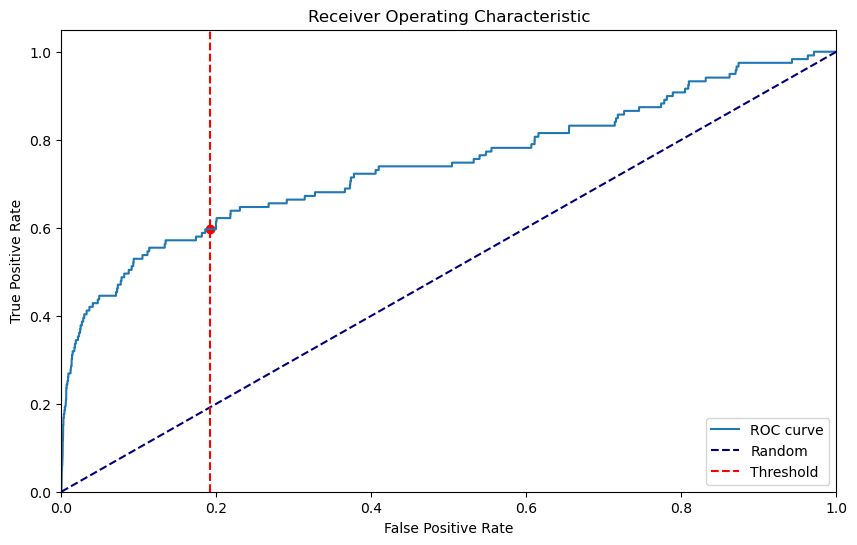

[0 1]
[0 1]
Results:
Accuracy: 0.8082
Balanced Accuracy: 0.7028
Recall: 0.5966
F1 Score: 0.0194
AUROC: 0.7438
AUPRC: 0.0573


In [34]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn import metrics
from collections import Counter
from sklearn.metrics import roc_curve


class BootstrappedSoftVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, n_estimators=10):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.estimators_ = []
        self.thereshold_ = 0.5

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for _ in range(self.n_estimators):
            # Create a bootstrap sample
            print(X.shape, y.shape)
            X_bootstrap, y_bootstrap = resample(X, y)
            
            # Create and fit a new estimator
            estimator = clone(self.base_estimator)
            estimator.fit(X_bootstrap, y_bootstrap)
            
            self.estimators_.append(estimator)
        avg_proba_train = self.predict_proba(X)
        fpr, tpr, thresholds = roc_curve(y, avg_proba_train[:, 1])
        self.threshold_ = thresholds[np.argmax(tpr - fpr)]
        return self

    def predict_proba(self, X):
        # Collect predictions from all estimators
        all_proba = np.array([est.predict_proba(X) for est in self.estimators_])
        
        # Average the probabilities (soft voting)
        avg_proba = np.mean(all_proba, axis=0)
        
        return avg_proba

    def predict(self, X, thre = 0.5):
        avg_proba = self.predict_proba(X)
        avg_proba_pos = avg_proba[:, 1]
        y = (avg_proba_pos > self.threshold_).astype(int)
        return y

def evaluate_bootstrapped_soft_voting(X_train = x_train, X_test = x_test, y_train = y_train, y_test = y_test, base_estimator = LogisticRegression(random_state=42, n_jobs=-1, class_weight=class_weight_options), n_estimators=10, test_size=0.2):
        
    # Create and fit the bootstrapped soft voting classifier
    bsvc = BootstrappedSoftVotingClassifier(base_estimator, n_estimators)
    bsvc.fit(X_train, y_train)
    
    # Make predictions
    y_pred = bsvc.predict(X_test)
    y_prob = bsvc.predict_proba(X_test)
    
    # For binary classification, we need the probability of the positive class
    y_prob_pos = y_prob[:, 1]
                        
                        
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')

    closest_threshold_index = np.argmin(np.abs(thresholds - bsvc.threshold_))
    closest_fpr = fpr[closest_threshold_index]
    closest_tpr = tpr[closest_threshold_index]
    plt.axvline(closest_fpr, color='red', linestyle='--', label='Threshold')
    plt.scatter(closest_fpr, closest_tpr, color='red')  # mark the point on the curve

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate metrics
    y_test2 = (y_test > 0.8).astype(int)
    unique_elements = np.unique(y_test2)

    print(unique_elements)
    unique_elements = np.unique(y_pred)

    print(unique_elements)
    results = {
        'Accuracy': metrics.accuracy_score(y_test2, y_pred),
        'Balanced Accuracy': metrics.balanced_accuracy_score(y_test2, y_pred),
        'Recall': metrics.recall_score(y_test2, y_pred, average='binary'),
        'F1 Score': metrics.f1_score(y_test2, y_pred, average='binary'),
        'AUROC': metrics.roc_auc_score(y_test, y_prob_pos),
        'AUPRC': metrics.average_precision_score(y_test, y_prob_pos)
    }
    
    return results

# Usage
class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]
class_weight_options = {0: 1, 1: scale_pos_weight}
base_estimator = LogisticRegression(random_state=42, n_jobs=-1, class_weight=class_weight_options)
results = evaluate_bootstrapped_soft_voting(x_train, x_test, y_train, y_test, base_estimator, n_estimators=10)

print("Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

In [37]:
y_train.shape

(135279,)

In [41]:
np.unique(y_train)

array([0., 1.])